In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
from ESRNN.m4_data import *
from ESRNN.utils_evaluation import evaluate_prediction_owa
from ESRNN.utils_visualization import plot_grid_prediction

In [21]:
seq_length = 24*7
target_seq_length = 24*2
input_size = 1
hidden_size = 10
num_layers = 1
output_size = 1
learning_rate = 0.01
epochs = 1000
batch_n = 128

In [22]:
X_train_df, y_train_df, X_test_df, y_test_df = prepare_m4_data(dataset_name="Hourly",
                                                               directory="../data/M4",
                                                               num_obs=414)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
y_train_df

,unique_id,ds,y
0,H1,1970-01-01 00:00:00,605.0
1,H1,1970-01-01 01:00:00,586.0
2,H1,1970-01-01 02:00:00,586.0
3,H1,1970-01-01 03:00:00,559.0
4,H1,1970-01-01 04:00:00,511.0
...,...,...,...
353495,H99,1970-01-29 23:00:00,27926.0
353496,H99,1970-01-30 00:00:00,26744.0
353497,H99,1970-01-30 01:00:00,25829.0
353498,H99,1970-01-30 02:00:00,25421.0


In [25]:
# def normalize_data(df, unique_id):
#     scaler = MinMaxScaler(feature_range=(-1, 1))
#     normalized_data = pd.DataFrame(columns=df.columns)
#     normalized_groups = []
    
#     # Normalize each time series individually
#     grouped = df.groupby(unique_id)
#     for _, group in grouped:
#         group_values = group['y'].values.reshape(-1, 1)
#         normalized_values = scaler.fit_transform(group_values)  # scale values
#         normalized_group = group.copy()
#         normalized_group['y'] = normalized_values.flatten() # copy scaled values over
#         normalized_groups.append(normalized_group)  # add to list of groups

#     normalized_data = pd.concat(normalized_groups, ignore_index=True)   # concatenate all groups into one

        
#     return normalized_data, scaler

In [26]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    scaled_data = scaled_data.flatten()

    return scaled_data, scaler
    

In [27]:
def create_sequence(df, unique_id, seq_length):
    # Xs, Ys = [], []
    sequence_dict = {}
    grouped = df.groupby(unique_id)

    for group_id, group in grouped:
        data = group['y'].values
        data, scaler = normalize_data(data)
        X, Y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:(i + seq_length)])
            Y.append(data[i + seq_length])
        sequence_dict[group_id] = {'X' : np.array(X), 'y': np.array(Y), 'scaler' : scaler}

    return sequence_dict

In [28]:
class GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        gru_out, _ = self.gru(x, h0)
        out = self.fc(gru_out[:, -1, :])
        return out

In [29]:
# model = GRU_Model(input_size, hidden_size, num_layers, output_size)
# model.to(device)

In [30]:
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
def train_model(model,
                criterion,
                optimizer,
                X_train,
                y_train,
                target_seq_length = target_seq_length,
                batch_size = 64,
                epochs=100):
    
    dataset = TensorDataset(X_train, y_train)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):

        model.train()

        for batch_idx, (sequences, targets) in enumerate(data_loader):

            sequences, targets = sequences.to(device), targets.to(device)

            # put default model grads to zero
            optimizer.zero_grad()

            # predict the output
            pred = model(sequences)

            # calculate the loss
            loss = criterion(pred, targets)

            # backpropagate the error
            loss.backward()

            # update the model parameters
            optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

    # generating forecasts
    model.eval()
    last_sequence = X_train[-1:].to(device)
    forecast_seq = torch.Tensor().to(device)

    for _ in range(target_seq_length):
        with torch.no_grad():
            
            next_step_forecast = model(last_sequence)

            forecast_seq = torch.cat((forecast_seq, next_step_forecast[:, -1:]), dim=1)

            last_sequence = torch.cat((last_sequence[:, 1:, :], next_step_forecast[:, -1:].unsqueeze(-1)), dim=1)
    
    return model, forecast_seq

In [32]:
sequences_dict = create_sequence(y_train_df, 'unique_id', seq_length)

In [33]:
y_hat_df_gru = X_test_df.copy().rename(columns={'x' : 'y_hat'})
y_hat_df_gru['y_hat'] = pd.Series(dtype='float64')

all_forecast_seq_descaled = []

for series_id in sequences_dict.keys():

    print(f'Series {series_id}')
    
    X_train = torch.from_numpy(sequences_dict[series_id]['X'].astype(np.float32)).unsqueeze(-1)
    y_train = torch.from_numpy(sequences_dict[series_id]['y'].astype(np.float32)).unsqueeze(-1)

    model = GRU_Model(input_size, hidden_size, num_layers, output_size)
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model_gru, forecast_seq = train_model(model,
                                          criterion=criterion,
                                          optimizer=optimizer,
                                          X_train=X_train,
                                          y_train=y_train,
                                          batch_size=batch_n,
                                          epochs=epochs)
    
    forecast_seq_descaled = sequences_dict[series_id]['scaler'].inverse_transform(forecast_seq.cpu().numpy()).flatten()
    # all_forecast_seq_descaled = np.hstack(all_forecast_seq_descaled, forecast_seq_descaled)
    all_forecast_seq_descaled.append(forecast_seq_descaled)

all_forecast_seq_descaled = np.hstack(all_forecast_seq_descaled)

y_hat_df_gru['y_hat'] = all_forecast_seq_descaled


Series H1
Epoch [100/1000], Loss: 0.0024209266994148493
Epoch [200/1000], Loss: 0.00214659096673131
Epoch [300/1000], Loss: 0.0012797651579603553
Epoch [400/1000], Loss: 0.0009997438173741102
Epoch [500/1000], Loss: 0.0008012061007320881
Epoch [600/1000], Loss: 0.0006616582977585495
Epoch [700/1000], Loss: 0.0007651936612091959
Epoch [800/1000], Loss: 0.0005479019018821418
Epoch [900/1000], Loss: 0.0005514691583812237
Epoch [1000/1000], Loss: 0.00040777167305350304
Series H10
Epoch [100/1000], Loss: 0.0015089455991983414
Epoch [200/1000], Loss: 0.0012165324296802282
Epoch [300/1000], Loss: 0.0009105765493586659
Epoch [400/1000], Loss: 0.00188733811955899
Epoch [500/1000], Loss: 0.000981481745839119
Epoch [600/1000], Loss: 0.0009525502100586891
Epoch [700/1000], Loss: 0.0009788377210497856
Epoch [800/1000], Loss: 0.0007298433338291943
Epoch [900/1000], Loss: 0.0008470111642964184
Epoch [1000/1000], Loss: 0.0007767635397613049
Series H100
Epoch [100/1000], Loss: 0.00998789630830288
Epoch

In [34]:
evaluate_prediction_owa(y_hat_df_gru, y_train_df, X_test_df, y_test_df, naive2_seasonality=24)

===============  Model evaluation  ==============
OWA: 1.603 
SMAPE: 24.029 
MASE: 4.548 


(1.603055815761915, 4.548061395832739, 24.029391611278548)

In [35]:
y_hat_df_gru.to_csv('../results/m4/y_hat_df_gru.csv', index=False)

In [177]:
forecast_test = sequences_dict['H1']['scaler'].inverse_transform(forecast_seq.cpu().numpy())

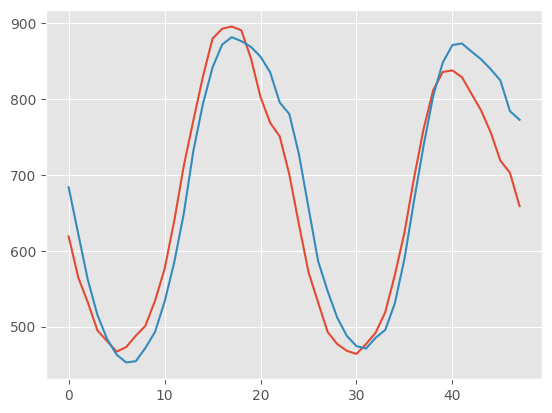

In [178]:
# plt.plot(forecast_seq.cpu().numpy()[0])
plt.plot(y_test_df[y_test_df['unique_id']=='H1']['y'])
plt.plot(forecast_test[0])